## Text Classification (and Model Explanation) with Huggingface BERT models

This notebook demonstrates finetuning a Huggingface BERT model on the task of text classification using the Tensorflow framework. It also provides examples on running predictions using the huggingface `pipeline` api and a custom prediction method.

In [2]:
!pip install -q transformers pandas tqdm tensorflow

You should consider upgrading via the '/opt/python/latest/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from transformers import BertTokenizerFast,TFBertForSequenceClassification
import numpy as np
import tensorflow as tf 
from tqdm.notebook import tqdm 

/opt/homebrew/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data 

We create sample data to illustrate training.

In [2]:
# example data political text has label 1, non-political text has label 0
data = [{'text': 'The president provided his stance on the wind mill policy today', 'label': 1},
{'text': 'The sun is shining bright and the day looks nice', 'label': 0},
{'text': 'The senators gathers to deliberate on climate change laws', 'label': 1},
{'text': 'Oh to be young and feel loves keen sting - Albus Dumbledore', 'label': 0}, 
]
data = data * 100
data = pd.DataFrame(data) 

## Initialize Model and Tokenizer

Download a pretrained model and tokenizer.

In [3]:
model_output_path = "models/text_classification"
model_path = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = TFBertForSequenceClassification.from_pretrained(model_path)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy()
              ) # can also use any keras loss fn

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Convert the text in the dataframe to a `tf.data` pipeline.

def get_train_ds(data, batch_size=32): 
  X_train, y_train = list(data.text), list(data.label) 
  train_encodings = tokenizer(X_train, truncation=True, padding=True)  
  train_ds = tf.data.Dataset.from_tensor_slices((
      dict(train_encodings),
      y_train
  ))   
  train_ds = train_ds.batch(batch_size) 
  return train_ds

## train and save model to disc
def train_on_slice(train_ds, num_epochs=1):
  model.fit(train_ds, epochs=num_epochs)   
  tokenizer.save_pretrained(f"{model_output_path}")
  model.save_pretrained(f"{model_output_path}")

In [5]:
train_ds = get_train_ds(data)
train_on_slice(train_ds) 

2022-05-18 22:34:50.855933: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 21s 970ms/step - loss: 0.2716 - sparse_categorical_accuracy: 0.9550


## Prediction with the Huggingface Pipeline api

We can make predictions with the huggingface pipeline api or write a custom prediction method.

In [6]:
from transformers import TextClassificationPipeline

tokenizer = BertTokenizerFast.from_pretrained(model_output_path)
model = TFBertForSequenceClassification.from_pretrained(model_output_path, id2label={1: 'political', 0: 'general'} ) # modify labels as needed. 
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)

Some layers from the model checkpoint at models/text_classification were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at models/text_classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [7]:
texts = data.text.tolist()[:5]
preds = pipe(texts)
preds

[{'label': 'political', 'score': 0.9679738879203796},
 {'label': 'general', 'score': 0.9443573951721191},
 {'label': 'political', 'score': 0.9692204594612122},
 {'label': 'general', 'score': 0.9519352912902832},
 {'label': 'political', 'score': 0.9679738879203796}]

In [8]:
preds_df = pd.DataFrame(preds)
preds_df["text"] = texts
preds_df.head()

,label,score,text
0,political,0.967974,The president provided his stance on the wind ...
1,general,0.944357,The sun is shining bright and the day looks nice
2,political,0.969220,The senators gathers to deliberate on climate ...
3,general,0.951935,Oh to be young and feel loves keen sting - Alb...
4,political,0.967974,The president provided his stance on the wind ...


## Custom Prediction Method 

Roll your own logic to batch. One potential improvement is to sort text first such that similar length text are in the same batch.   

In [9]:
def extract_predictions( text, model, tokenizer, batch_size=256): 
  text = sorted(text, key=len)
  a_preds = []
  a_scores = []  
  chunks = range(0,len(text), batch_size)
  for i,x, in tqdm(enumerate(chunks), desc="batching and predicting", total=len(chunks)):
    start, end = x, x+batch_size
    stext = text[start: end] 
    data_encodings = tokenizer(stext, truncation=True, padding=True)  
    ds = tf.data.Dataset.from_tensor_slices(dict(data_encodings)).batch(batch_size)  

    preds = model.predict(ds)["logits"] 
    classes = np.argmax(preds, axis=1).tolist() 
    probs = tf.nn.softmax(preds) # get probabilities from logits
    scores = np.amax(probs, axis=1).tolist()   
    a_preds.extend(classes)
    a_scores.extend(scores) 
   
  ans = []
  for i in range(len(a_preds)):  # map labels to label titles 
    ans.append({
        "label": "general" if a_preds[i] == 0 else "political",
        "score": a_scores[i]
    })
  result = pd.DataFrame(ans) 
  return result

In [10]:
preds_df = extract_predictions(texts, model, tokenizer)
preds_df["text"] = texts
preds_df.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


batching and predicting:   0%|          | 0/1 [00:00<?, ?it/s]

,label,score,text
0,general,0.944357,The president provided his stance on the wind ...
1,political,0.969220,The sun is shining bright and the day looks nice
2,general,0.951935,The senators gathers to deliberate on climate ...
3,political,0.967974,Oh to be young and feel loves keen sting - Alb...
4,political,0.967974,The president provided his stance on the wind ...


## Explain the Model with Vanilla Gradients

In [12]:
def get_gradients(text, model, tokenizer):
  
  def get_correct_span_mask(correct_index, token_size):
    span_mask = np.zeros((1, token_size))
    span_mask[0, correct_index] = 1
    span_mask = tf.constant(span_mask, dtype='float32')
    return span_mask

  embedding_matrix = model.bert.embeddings.weights[0]
  encoded_tokens = tokenizer(text, return_tensors="tf") 
  token_ids = list(encoded_tokens["input_ids"].numpy()[0])
  vocab_size = embedding_matrix.get_shape()[0]

  # convert token ids to one hot. We can't differentiate wrt to int token ids hence the need for one hot representation
  token_ids_tensor = tf.constant([token_ids], dtype='int32')
  token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size) 
  
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    # (i) watch input variable
    tape.watch(token_ids_tensor_one_hot)
 
    # multiply input model embedding matrix; allows us do backprop wrt one hot input 
    inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)  

    # (ii) get prediction
    pred_scores = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"] } ).logits
    max_class = tf.argmax(pred_scores, axis=1).numpy()[0] 

    score_mask = get_correct_span_mask(max_class, pred_scores.shape[1])
    # end_output_mask = get_correct_span_mask(answer_end, len(token_ids))
  
    # zero out all predictions outside of the correct  prediction class; we want to get gradients wrt to just this class  
    predict_correct_class = tf.reduce_sum(pred_scores * score_mask ) 

    # (iii) get gradient of input with respect to both start and end output
    gradient_non_normalized = tf.norm(
        tape.gradient(predict_correct_class, token_ids_tensor_one_hot),axis=2)
    
    # (iv) normalize gradient scores and return them as "explanations"
    gradient_tensor = (
        gradient_non_normalized /
        tf.reduce_max(gradient_non_normalized)
    )
    gradients = gradient_tensor[0].numpy().tolist() 
    token_words = tokenizer.convert_ids_to_tokens(token_ids)

    prediction_label= "political" if max_class == 1 else "general"
  return gradients, token_words , prediction_label
 
 

In [13]:
import matplotlib.pyplot as plt

def plot_gradients(tokens,gradients, title): 
  """ Plot  explanations
  """
  plt.figure(figsize=(18,3)) 
  xvals = [ x + str(i) for i,x in enumerate(tokens)]
  colors =  [ (0,0,1, c) for c in (gradients) ] 
  plt.tick_params(axis='both', which='minor', labelsize=29)
  p = plt.bar(xvals, gradients, color=colors, linewidth=1 )
  plt.title(title) 
  p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90) 

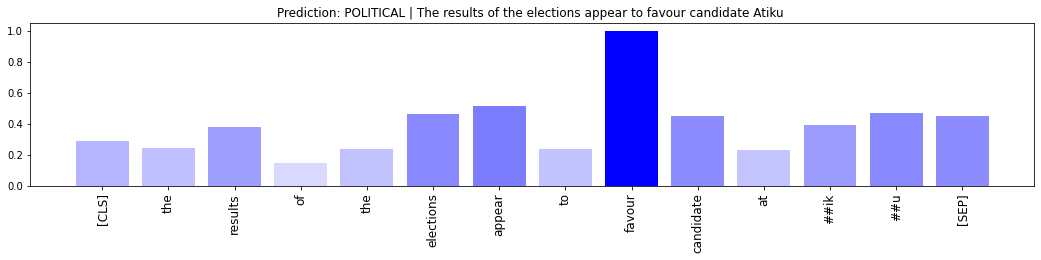

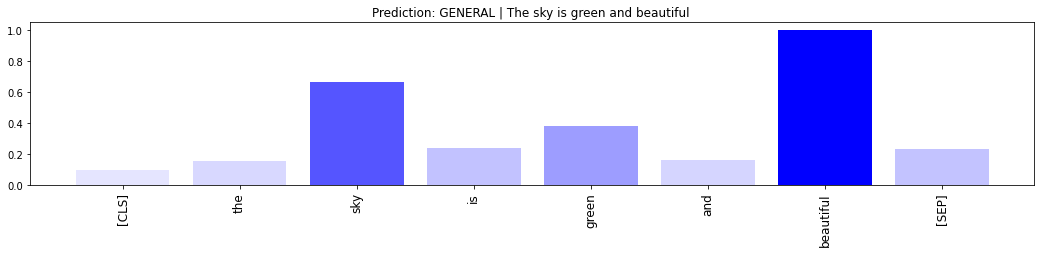

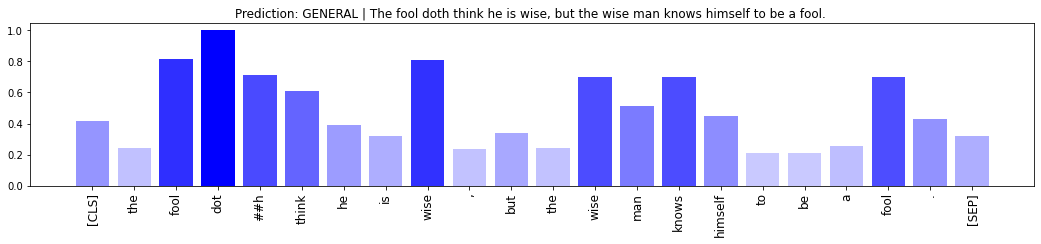

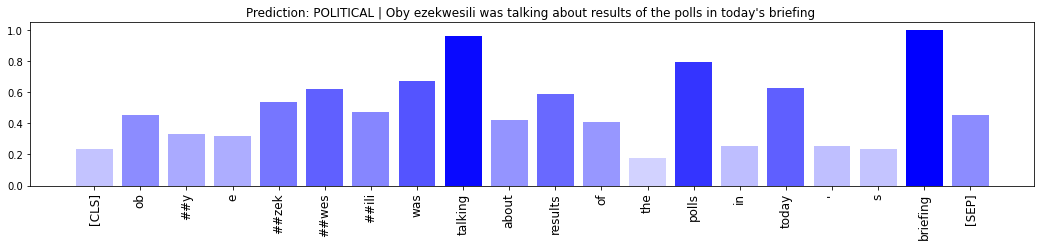

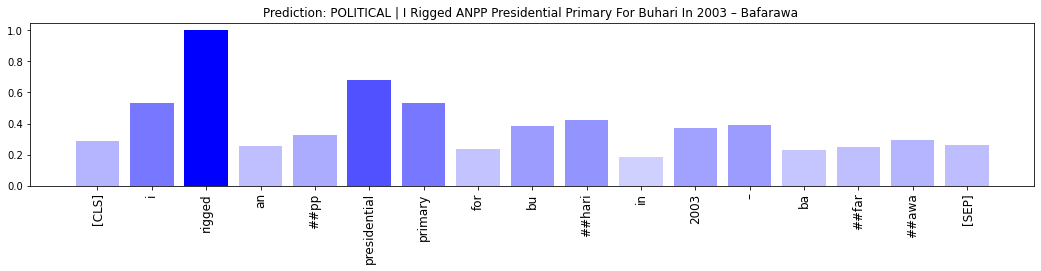

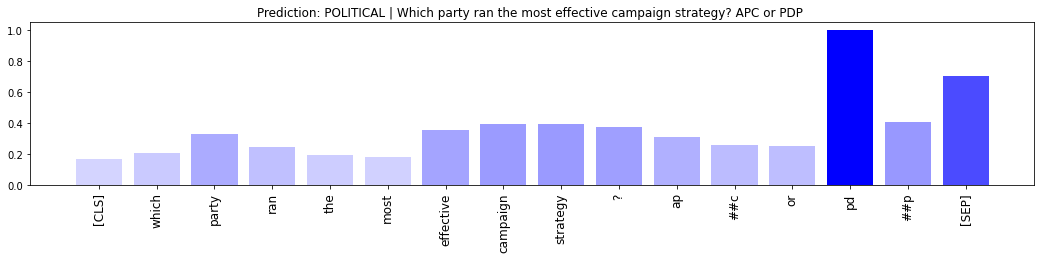

In [14]:
texts = ["The results of the elections appear to favour candidate Atiku",
         "The sky is green and beautiful",
         "The fool doth think he is wise, but the wise man knows himself to be a fool.",
         "Oby ezekwesili was talking about results of the polls in today's briefing",
         "I Rigged ANPP Presidential Primary For Buhari In 2003 – Bafarawa",
         "Which party ran the most effective campaign strategy? APC or PDP"]
# texts = sorted(texts, key=len)
 
for text in texts:
    gradients, words, label = get_gradients(text, model, tokenizer)
    plot_gradients(words, gradients, f"Prediction: {label.upper()} | {text} ")
     
